In [52]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


数据源：https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/

In [53]:
data = pd.read_csv('spam.csv',encoding='ISO-8859-1')
data.head()



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [54]:
data.shape
# print(data['v1'].dtype)


(5572, 5)

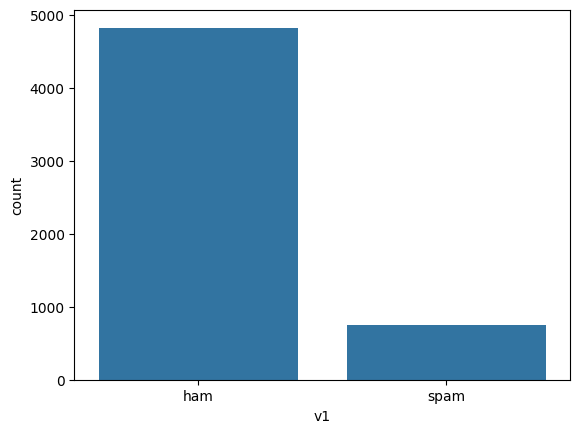

In [55]:
sns.countplot(x='v1', data=data)
plt.show()


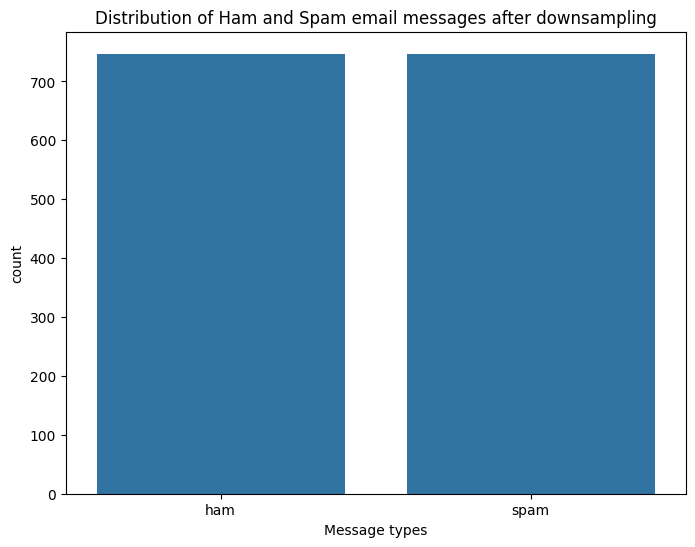

In [56]:
# Downsampling to balance the dataset
ham_msg = data[data.v1 == 'ham']
spam_msg = data[data.v1 == 'spam']
ham_msg = ham_msg.sample(n=len(spam_msg),
						random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data,x='v1')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')
plt.show()


In [57]:
balanced_data['v2'] = balanced_data['v2'].str.replace('Subject', '')
balanced_data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"I am late,so call you tomorrow morning.take ca...",NaN,NaN,NaN
1,ham,U r too much close to my heart. If u go away i...,NaN,NaN,NaN
2,ham,Wait &lt;#&gt; min..,NaN,NaN,NaN
3,ham,Can you call me plz. Your number shows out of ...,NaN,NaN,NaN
4,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,NaN,NaN,NaN


In [58]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['v2']= balanced_data['v2'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,I am lateso call you tomorrow morningtake care...,NaN,NaN,NaN
1,ham,U r too much close to my heart If u go away i ...,NaN,NaN,NaN
2,ham,Wait ltgt min,NaN,NaN,NaN
3,ham,Can you call me plz Your number shows out of c...,NaN,NaN,NaN
4,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,NaN,NaN,NaN


In [59]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['v2'] = balanced_data['v2'].apply(lambda text: remove_stopwords(text))
balanced_data.head()



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,lateso call tomorrow morningtake care sweet dr...,NaN,NaN,NaN
1,ham,u r much close heart u go away shattered plz stay,NaN,NaN,NaN
2,ham,wait ltgt min,NaN,NaN,NaN
3,ham,call plz number shows coveragd area urgnt call...,NaN,NaN,NaN
4,ham,maybe woke fucking 3 wouldnt problem,NaN,NaN,NaN


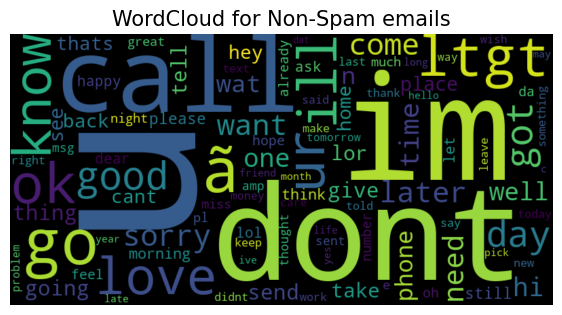

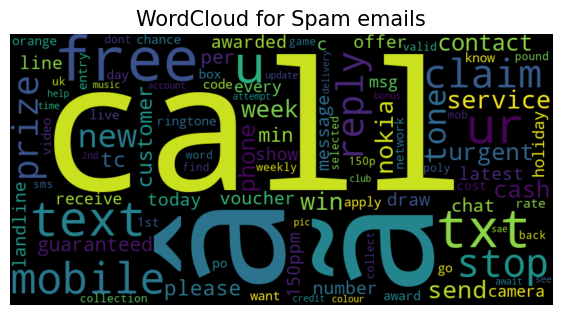

In [60]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['v2'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['v1'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['v1'] == 'spam'], typ='Spam')


In [61]:
# 二分类，把垃圾邮件和非垃圾邮件值变为1和0
# 创建一个映射字典
# balanced_data.head()
#
# 重新进行映射
mapping_dict = {'ham': 0, 'spam': 1}
balanced_data['v1'] = balanced_data['v1'].map(mapping_dict)

# 打印结果
print(balanced_data)



      v1                                                 v2 Unnamed: 2  \
0      0  lateso call tomorrow morningtake care sweet dr...        NaN   
1      0  u r much close heart u go away shattered plz stay        NaN   
2      0                                      wait ltgt min        NaN   
3      0  call plz number shows coveragd area urgnt call...        NaN   
4      0               maybe woke fucking 3 wouldnt problem        NaN   
...   ..                                                ...        ...   
1489   1  want explicit sex 30 secs ring 02073162414 cos...        NaN   
1490   1  asked 3mobile 0870 chatlines inclu free mins i...        NaN   
1491   1  contract mobile 11 mnths latest motorola nokia...        NaN   
1492   1  reminder o2 get 250 pounds free call credit de...        NaN   
1493   1  2nd time tried 2 contact u u ã¥â£750 pound pri...        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        N

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(balanced_data['v2'], balanced_data['v1'], test_size=0.2, random_state=42)

# 构建模型
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 性能度量
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("准确性:", accuracy)
print("分类报告:\n", classification_rep)


准确性: 0.9531772575250836
分类报告:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       145
           1       0.97      0.94      0.95       154

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299



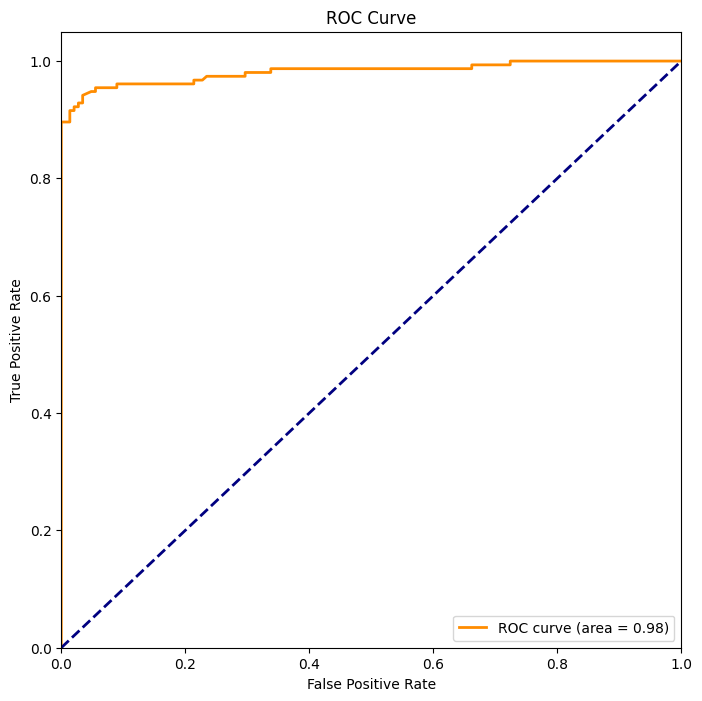

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 读取数据

# 分割数据集
X = balanced_data['v2']
y = balanced_data['v1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 文本处理：将文本转换为数字序列
max_words = 1000  # 假设只考虑最频繁的1000个单词
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# 填充序列，确保输入数据具有相同的长度
max_len = 100  # 假设限定邮件内容的最大长度为100个词
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len)

# 构建神经网络模型
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

# 在训练集和测试集上进行预测
y_train_pred = (model.predict(X_train_pad) > 0.5).astype(int)
y_test_pred = (model.predict(X_test_pad) > 0.5).astype(int)

# 计算性能度量
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

train_report = classification_report(y_train, y_train_pred)
test_report = classification_report(y_test, y_test_pred)

# 打印性能度量结果
print("训练准确度：", train_accuracy)
print("测试准确度：", test_accuracy)

print("\n训练混淆矩阵：")
print(train_conf_matrix)
print("\n测试混淆矩阵：")
print(test_conf_matrix)

print("\n训练分类报告：")
print(train_report)
print("\n测试分类报告：")
print(test_report)



Epoch 1/5


30/30 [==============================] - 5s 74ms/step - loss: 0.5229 - accuracy: 0.8013 - val_loss: 0.3126 - val_accuracy: 0.8745
Epoch 2/5
30/30 [==============================] - 1s 42ms/step - loss: 0.2233 - accuracy: 0.9174 - val_loss: 0.1763 - val_accuracy: 0.9247
Epoch 3/5
30/30 [==============================] - 1s 41ms/step - loss: 0.1222 - accuracy: 0.9623 - val_loss: 0.1554 - val_accuracy: 0.9372
Epoch 4/5
30/30 [==============================] - 1s 41ms/step - loss: 0.0714 - accuracy: 0.9770 - val_loss: 0.1510 - val_accuracy: 0.9414
Epoch 5/5
10/10 [==============================] - 0s 13ms/step
训练准确度： 0.9799163179916318
测试准确度： 0.9464882943143813

训练混淆矩阵：
[[593   9]
 [ 15 578]]

测试混淆矩阵：
[[140   5]
 [ 11 143]]

训练分类报告：
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       602
           1       0.98      0.97      0.98       593

    accuracy                           0.98      1195
   macro avg       0.98      0